In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import random
import pickle
import osmnx as ox
import copy
import json
import os
import glob

In [17]:
"""
Input
"""
seed = 0
example = 9
num_nodes = 50
num_clients = 10
budget = 2
num_auto = 3
num_non_auto = 3





# Write the input to a file
input = ['seed', 'example', 'num_nodes', 'num_clients', 'budget', 'num_auto', 'num_non_auto']
input_dict = dict(zip(input, [seed, example, num_nodes, num_clients, budget, num_auto, num_non_auto]))
path = 'generic-vrp-'+str(example)

if not os.path.exists(path):
    os.mkdir('generic-vrp-' + str(example))
with open('generic-vrp-' +str(example) + '/input.json', 'w') as outfile:
    json.dump(input_dict, outfile)



In [18]:
"""
Set the seed
"""
random.seed(seed)
np.random.seed(seed)

In [19]:
"""
Build a graph
"""

# Read the network data 
G = pickle.load(open("Manhattan_network.p", "rb"))


# Generate the set of nodes of a subgraph by BFS
def graph_generator(G, num_nodes):
    V = list(G.nodes)
    E = list(G.edges)
    s = random.sample(V, 1)[0]

    visited = [s]
    frontier = [s]
    while len(visited) < num_nodes and len(frontier) > 0:
        i = frontier.pop(0)
        for j in G.neighbors(i):
            if j not in visited:
                visited.append(j)
                frontier.append(j)
    
    return visited

tmp_V = graph_generator(G, num_nodes)
G = G.subgraph(tmp_V)


# Extract the strongly connected components
tmp_V = max(nx.strongly_connected_components(G), key = len)
G = G.subgraph(list(tmp_V))
V = list(G.nodes)
E = list(G.edges)

# label mapping
old_to_new = {}
new_to_old = {}
index = 0
for i in V:
    new_to_old[index] = i
    old_to_new[i] = index
    index += 1

In [20]:
"""
Set parameters (key control params, as input, are in the first chunk)
"""

## Depots
K = random.sample(V, 1)

## Trucks
num_truck = num_auto + num_non_auto ### The first half are auto trucks
truck = np.arange(num_truck)

truck_range = (np.random.random(len(truck))) * 50 * 1600
truck_capacity = 10

# Fixed cost to dispatch a truck
truck_cost = np.repeat(100, len(truck))


## Clients
D = random.sample(list(set(V) - set(K)), num_clients)

demand = np.random.lognormal(0.1, 1, size=len(D))
demand[demand >= truck_capacity] = truck_capacity


## Time discretization

# The length of time intervals (in minutes)
gran = 1
# The # of operational hours (in hours)
op = 3
# Time span (in seconds)
T = op * 3600

num_interval = int((60 / gran) * op)
Q = np.arange(num_interval)
a = np.arange(0, T, gran * 60)
b = a + gran * 60



/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


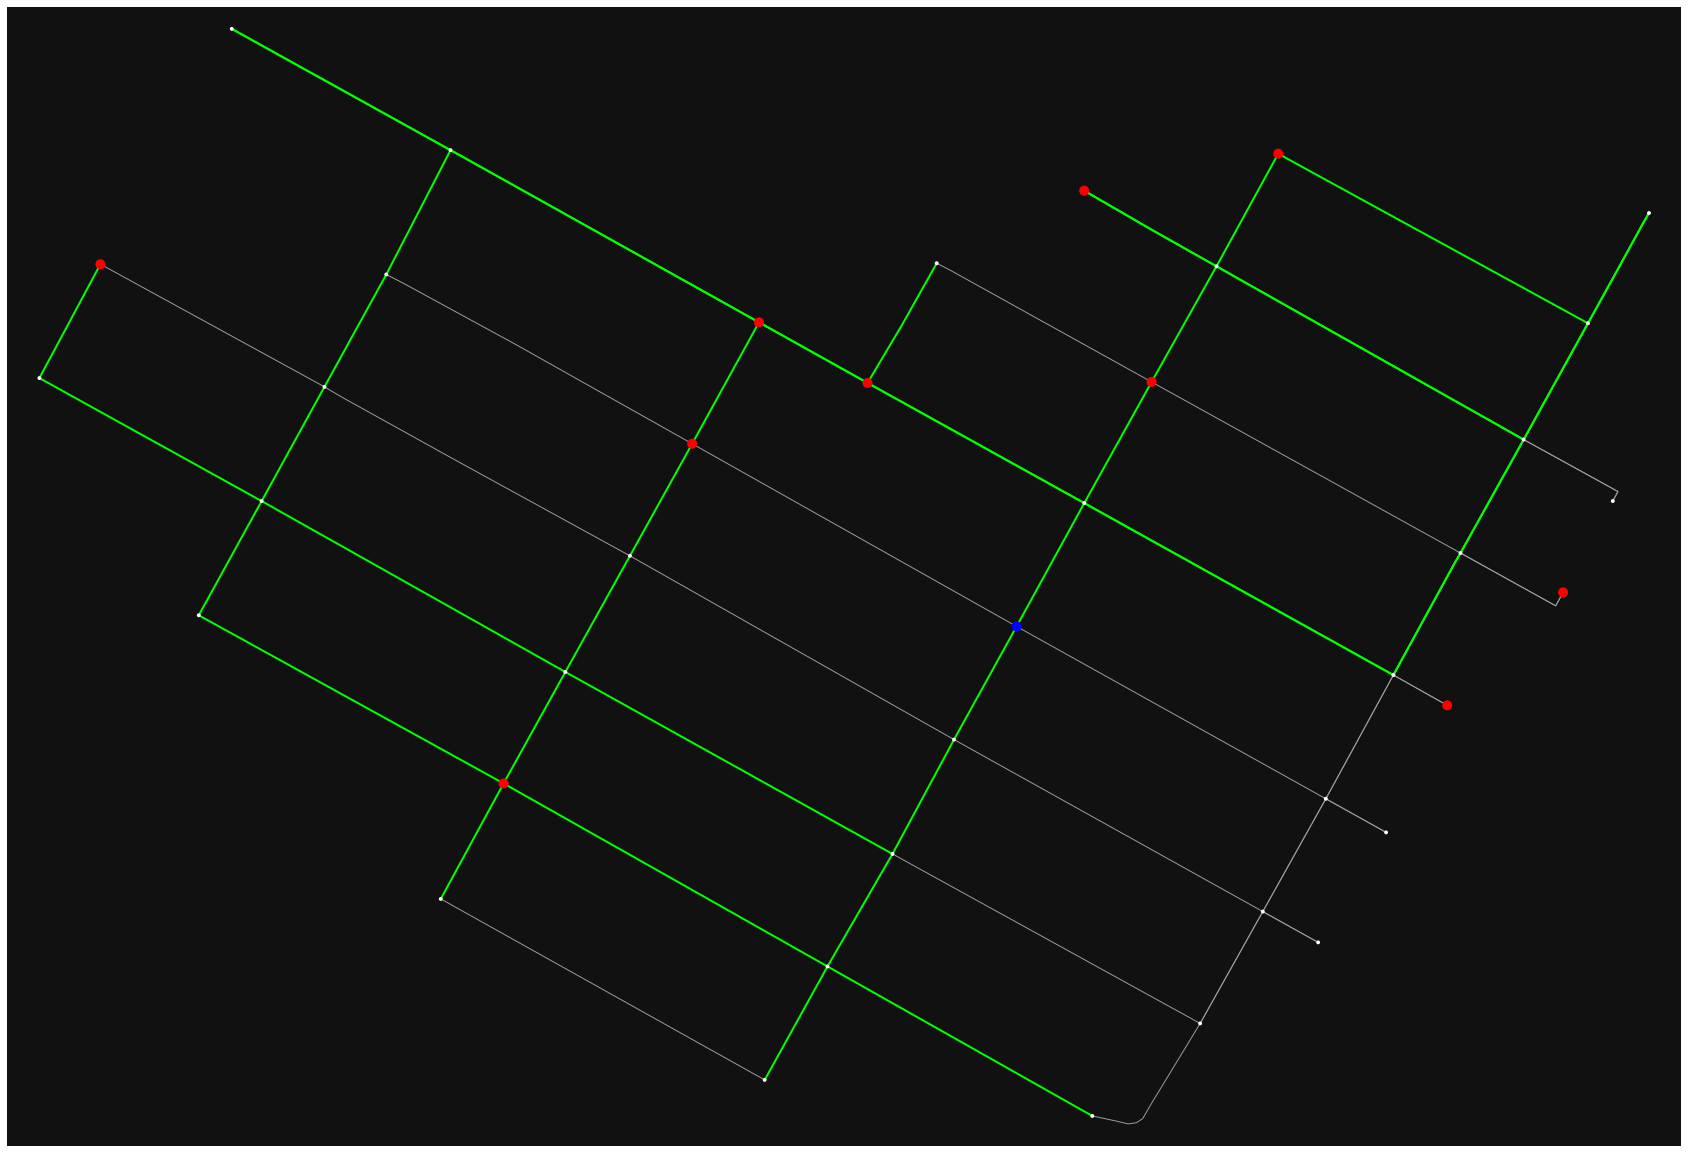

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [21]:
"""
Visualization
"""

# index_K = [i for i in range(len(V)) if V[i] in K]
# index_D = [i for i in range(len(V)) if V[i] in D]
index_auto_E = [i for i in range(len(E)) if G.edges[E[i]]['highway'] == 'primary' or G.edges[E[i]]['highway'] == 'secondary'] 
node_color = ['w' for _ in range(len(V))]
node_size = [15 for _ in range(len(V))]
edge_color = ['#999999' for _ in range(len(E))]
edge_linewidth = [1 for _ in range(len(E))]

for i in K:
    idx = old_to_new[i]
    node_color[idx] = 'b'
    node_size[idx] = 100
for i in D:
    idx = old_to_new[i]
    node_color[idx] = 'r'
    node_size[idx] = 100
for idx in index_auto_E:
    edge_color[idx] = '#00FF00'
    edge_linewidth[idx] = 2

ox.plot_graph(G, node_color = node_color, node_size = node_size, edge_color = edge_color, 
                edge_linewidth = edge_linewidth, figsize = (30, 30), save = True, filepath = 'generic-vrp-' + str(example) + '/network.png')

In [22]:
"""
Cost and travel time
"""

speed = 3.3528 # in meter/second

f1 = 0.8
f2 = 1


for e in E:
    e = (e[0], e[1], 0)
    G.edges[e]['travel_time'] = G.edges[e]['length'] / speed

for e in E:
    e = (e[0], e[1], 0)
    if G.edges[e]['highway'] == 'primary' or G.edges[e]['highway'] == 'secondary':
        G.edges[e]['auto_cost'] = f1 * G.edges[e]['length']
        G.edges[e]['non_auto_cost'] = G.edges[e]['length']
    else:
        G.edges[e]['auto_cost'] = f2 * G.edges[e]['length']
        G.edges[e]['non_auto_cost'] = G.edges[e]['length']

In [23]:
"""
Compute all shortest paths among clients
"""
K_D = K + D
cost_non_auto = np.zeros((num_clients + 1, num_clients + 1))
cost_auto = np.zeros((num_clients + 1, num_clients + 1))
path_non_auto = {}
path_auto = {}

for i in range(len(K_D)):
    for j in range(len(K_D)):
        if i!=j:
            cost_non_auto[i][j] = nx.shortest_path_length(G, K_D[i], K_D[j], weight='non_auto_cost')
            cost_auto[i][j] = nx.shortest_path_length(G, K_D[i], K_D[j], weight='auto_cost')

            path_non_auto[str(K_D[i])+'-'+str(K_D[j])] = nx.shortest_path(G, K_D[i], K_D[j], weight='non_auto_cost')
            path_auto[str(K_D[i])+'-'+str(K_D[j])] = nx.shortest_path(G, K_D[i], K_D[j], weight='auto_cost')
            

In [24]:
"""
A generic VRP solver based on matric closure
"""

# Create a new model
model_2 = gp.Model('generic_vrp')

# Set the file path for logging
path = 'generic-vrp-' + str(example) + '/generic_vrp_log.txt'
if os.path.exists(path):
    os.remove(path)
model_2.Params.LogFile = path

# Parameters tuning for the MIP solver
# model_2.Params.MIPFocus = 3 # Focusing on the phase 2 (getting good quality solutions)
# model_2.Params.MIPGap = 0 # Specify the terminating duality gap

# Create variables
x = model_2.addMVar((len(K_D), len(K_D), num_truck), vtype=GRB.BINARY)
y = model_2.addMVar((len(K_D), num_truck), vtype=GRB.BINARY)
h = model_2.addMVar((len(D), num_truck), vtype=GRB.CONTINUOUS, ub=sum(demand))

# Specify an initial feasible solution
# x.setAttr("Start", x_init)
# y.setAttr("Start", y_init)
# h.setAttr("Start", h_init)

# Constraints
for i in range(len(K_D)):
    model_2.addConstrs(sum(x[:, i, m]) == sum(x[i, :, m]) for m in truck)
    model_2.addConstrs(x[i, i, m] == 0 for m in truck)
    model_2.addConstrs(sum(x[:, i, m]) == y[i, m] for m in truck)

model_2.addConstrs(sum(y[i, :]) == 1 for i in range(1, len(K_D)))

model_2.addConstr(sum(y[0, :]) <= num_truck)

model_2.addConstrs(sum(x[i, j, m] * cost_non_auto[i][j] for i in range(len(K_D)) for j in range(len(K_D))) <= truck_range[m] 
                   for m in truck)

model_2.addConstrs(sum(demand[i] * y[i+1, m] for i in range(len(D))) <= truck_capacity
                for m in truck)

for i in range(len(D)):
    for j in range(len(D)):
        model_2.addConstrs(h[j, m] >= h[i, m] + sum(demand) * (x[i+1, j+1, m] - 1) + demand[i] for m in truck)
model_2.addConstrs(h[i, m] >= demand[i] for m in truck for i in range(len(D)))

# Objective
model_2.setObjective(sum(x[i, j, m] * cost_auto[i][j] for i in range(len(K_D)) for j in range(len(K_D)) for m in truck[: num_auto]) +
                     sum(x[i, j, m] * cost_non_auto[i][j] for i in range(len(K_D)) for j in range(len(K_D)) for m in truck[num_auto :]) +
                     y[0, :] @ truck_cost, GRB.MINIMIZE)

# Solve the VRP
model_2.optimize()

Set parameter LogFile to value "generic-vrp-9/generic_vrp_log.txt"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads
Optimize a model with 881 rows, 852 columns and 4704 nonzeros
Model fingerprint: 0x6f35963c
Variable types: 60 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [6e+01, 1e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [9e-01, 6e+04]
Presolve removed 193 rows and 66 columns
Presolve time: 0.03s
Presolved: 688 rows, 786 columns, 6200 nonzeros
Variable types: 60 continuous, 726 integer (726 binary)
Found heuristic solution: objective 6023.8123245

Root relaxation: objective 2.415771e+03, 149 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2415.77059    0   40

In [25]:
"""
Extract the routes (generic VRP)
"""

route = []
for m in truck:
    if y[0, m].X == 0:
        route.append([])
        continue
    route_m = []
    start = 0
    next = np.where(x[0, :, m].X > .5)[0][0]
    while next != 0:
        if m < num_auto:
            route_m = route_m + path_auto[str(K_D[start])+'-'+str(K_D[next])][1:]
        else:
            route_m = route_m + path_non_auto[str(K_D[start])+'-'+str(K_D[next])][1:]
        start = next
        next = np.where(x[next, :, m].X > .5)[0][0]
    if m < num_auto:
        route_m = route_m + path_auto[str(K_D[start])+'-'+str(K_D[0])][1:]
    else:
        route_m = route_m + path_non_auto[str(K_D[start])+'-'+str(K_D[0])][1:]
    route_m.insert(0, K_D[0])
    route.append(route_m)
    

In [26]:
"""
Write the routes to a json file (generic VRP)
"""

dict_routes = dict(zip(range(len(route)), route))
with open('generic-vrp-' +str(example) + '/routes.json', 'w') as outfile:
    json.dump(dict_routes, outfile)

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


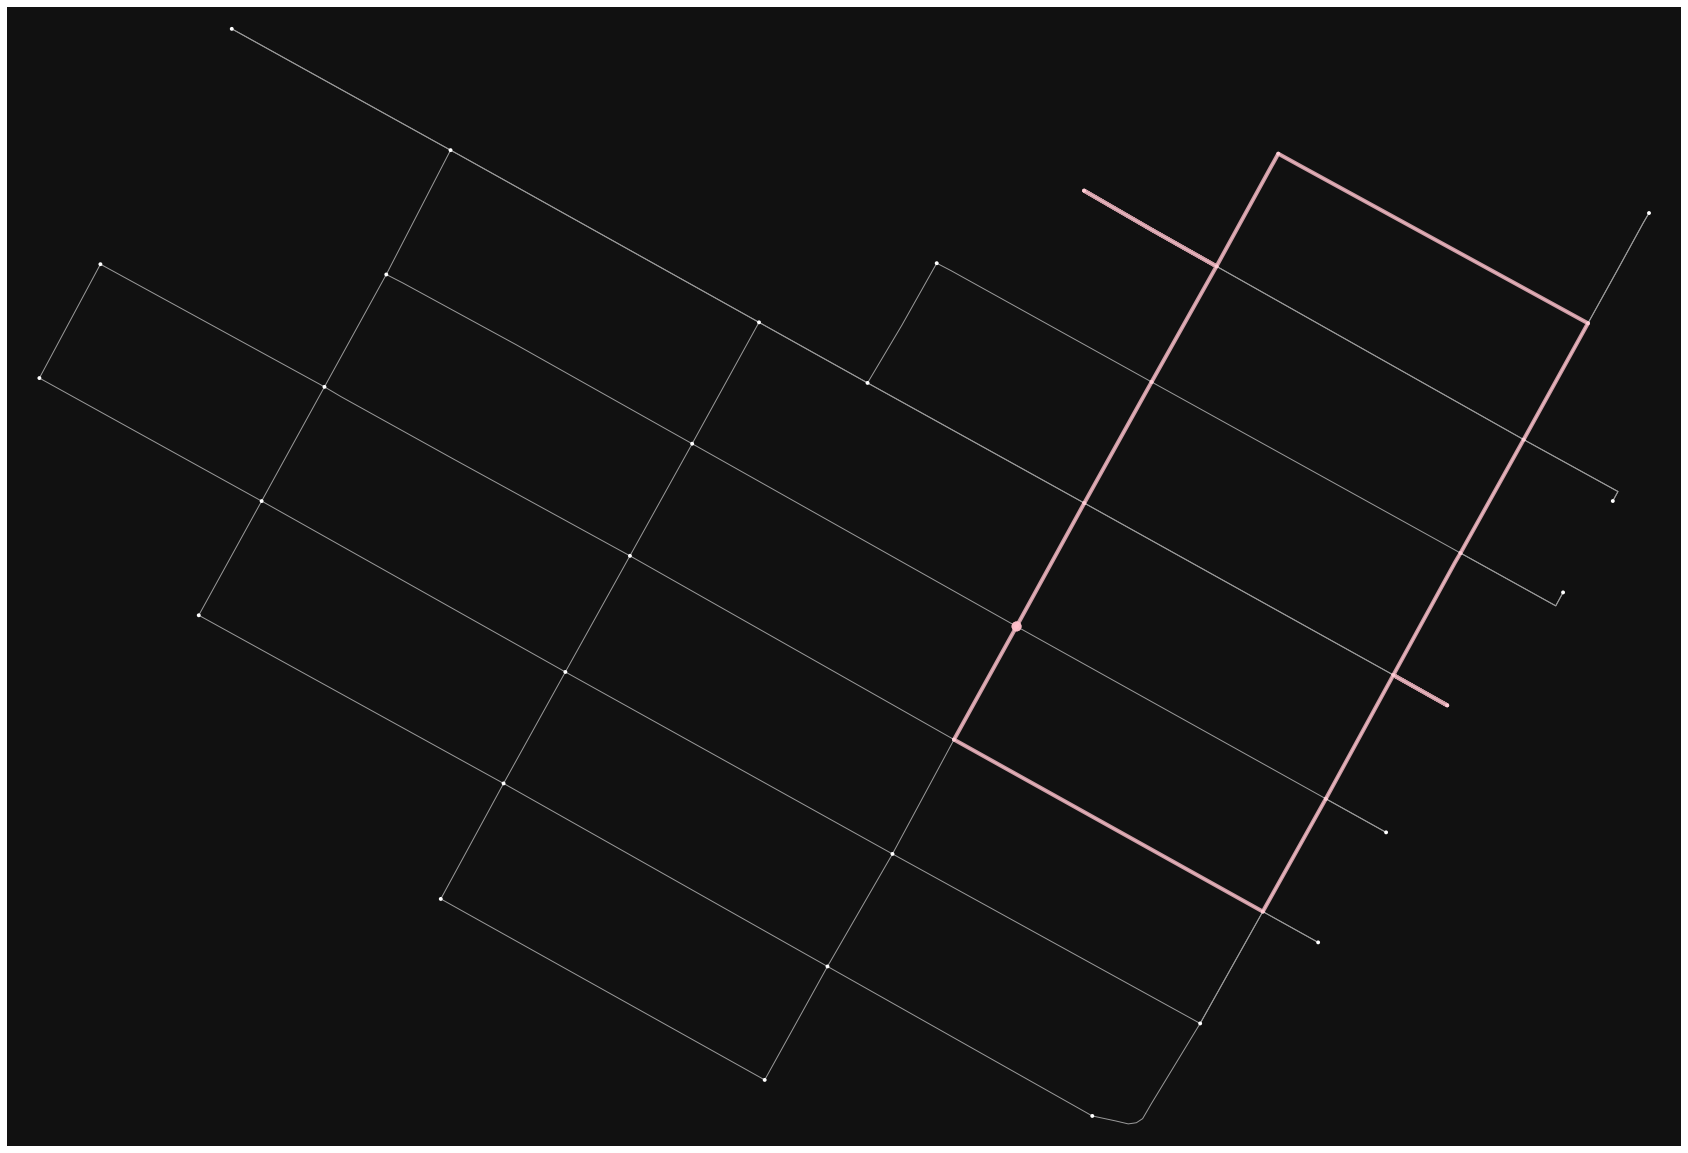

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


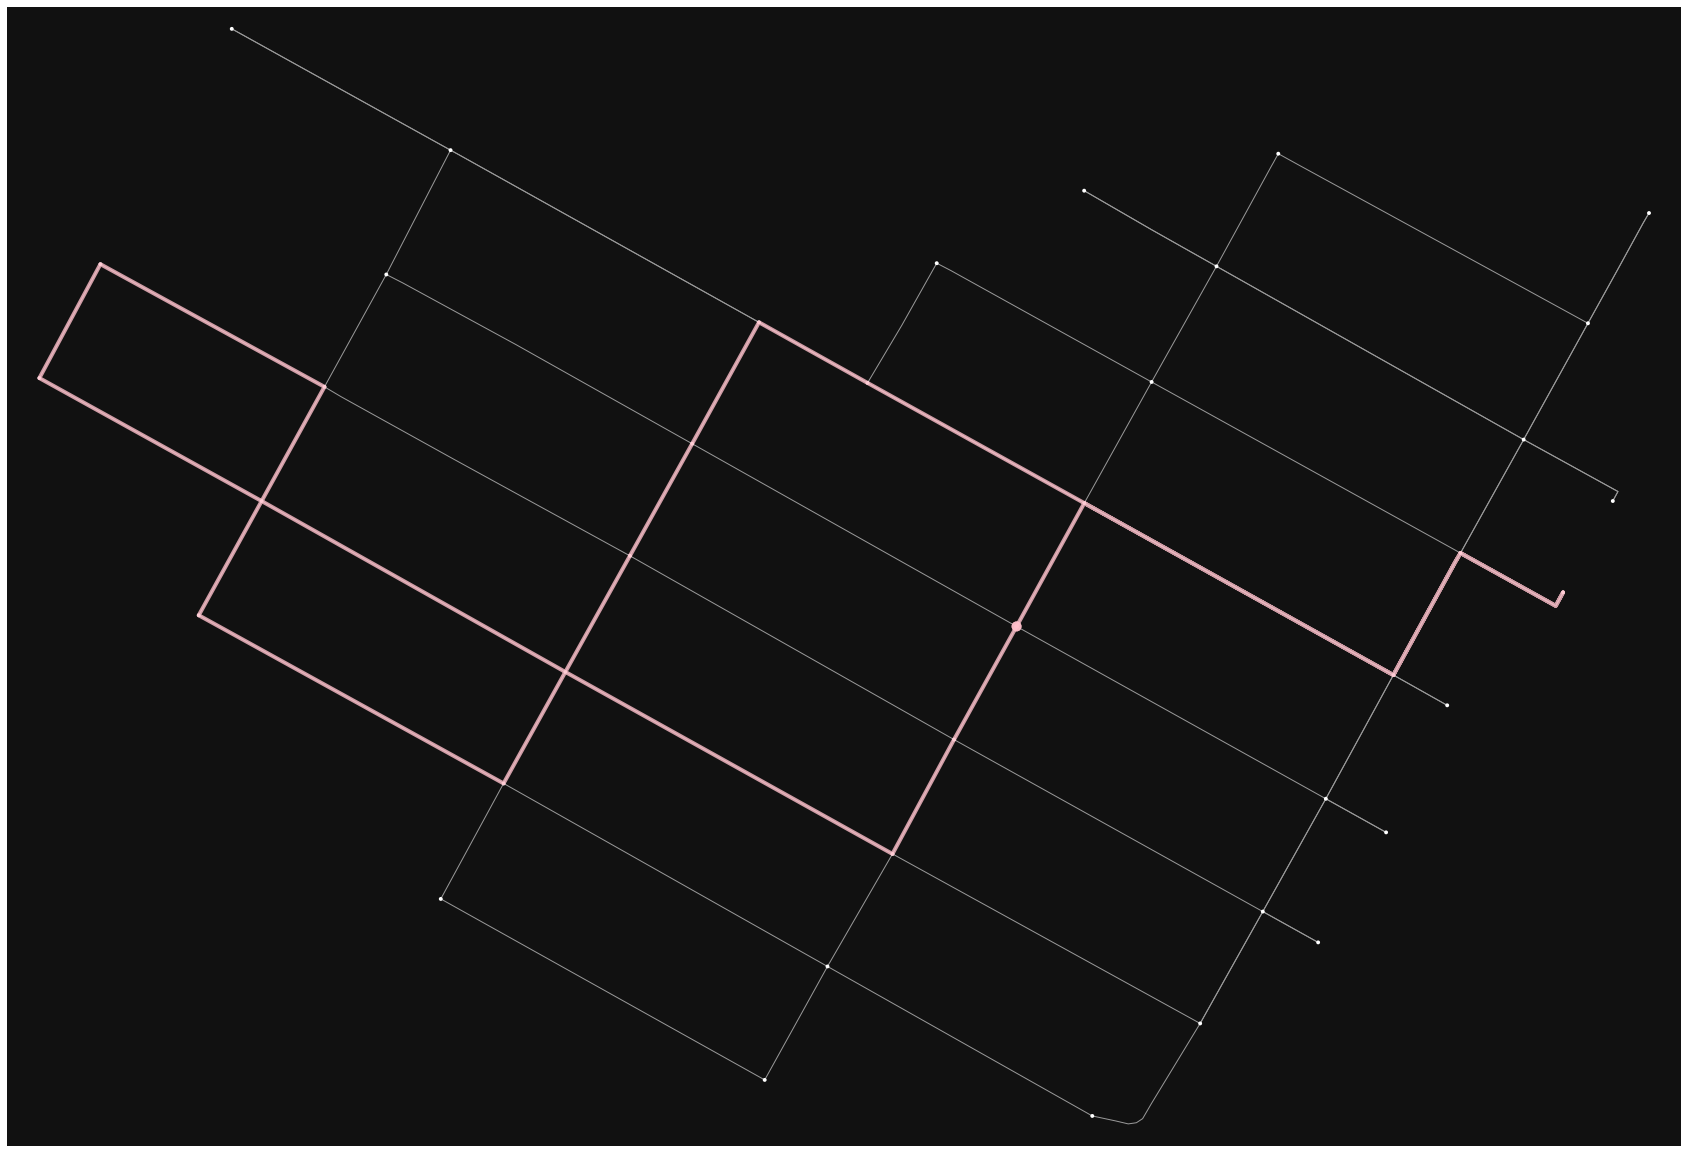

In [27]:
"""
Visualize all routes and output the figures (generic VRP)
"""


# Remove old figures
for figure in glob.glob("generic-vrp-"+str(example)+'/route-*'):
    os.remove(figure)

counter = 0
for m in range(len(route)):
    if len(route[m]) <= 1:
        counter += 1
    if len(route[m]) > 1:
        if m < num_auto:
            color = '#FFC0CB'
        else:
            color = '#00FFFF'
        ox.plot.plot_graph_route(G, route[m], route_color = color, route_linewidth=4,
                        route_alpha=0.8, orig_dest_size=100, figsize = (30, 30), save = True, filepath = 'generic-vrp-' + str(example) + '/route-' + str(m - counter + 1)+'.png')

In [28]:
"""
Simulation for the generic VRP
"""


# A helper function to keep track of time
# INPUT: a list of route
# OUTPUT: a list of time stamps 
def node_time(r):
    time_stamp = [(r[0], 0)]
    for i in range(1, len(r)):
        # time = time_stamp[i-1][1] + 2
        # print(r[i-1], r[i])
        time = time_stamp[i-1][1] + G[r[i-1]][r[i]][0]['travel_time']
        time_stamp.append((r[i], time))
    return time_stamp
        
        
# Construct the matrix indicating whether or not remote control is needed
control = np.zeros((num_truck, num_interval))
for m in truck[: num_auto]:
    if route[m] == []:
        continue

    time_stamp = node_time(route[m])
    for q in Q:
        for i in range(len(time_stamp)-1):
            b1 = (a[q] <= time_stamp[i+1][1])
            b2 = (b[q] >= time_stamp[i][1])
            if b1 and b2:
                s = time_stamp[i][0]
                t = time_stamp[i+1][0]
                b3 = ((G[s][t][0]['highway'] == 'primary') or (G[s][t][0]['highway'] == 'secondary'))
                if b3:
                    control[m][q] = 0
                else:
                    control[m][q] = 1

# time_stamp = node_time(route[2])
# print(T, time_stamp[-1], num_interval)


In [29]:

num_control = {'control_vector': list(np.sum(control, axis=0))}
with open('generic-vrp-' +str(example) + '/control.json', 'w') as outfile:
    json.dump(num_control, outfile)

In [30]:
list(np.sum(control, axis=0))

[0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0